Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# FineTuning NLP Models with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use the FLAML library to fine tune an NLP language model with hyperparameter search. 

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `nlp,ray,notebook` and `blendsearch` option:
```bash
pip install flaml[nlp,ray,notebook,blendsearch];
```

In [2]:
!pip install flaml[nlp,ray,notebook,blendsearch];

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 KB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 KB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.0/113.0 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 KB 30.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=48c95a4ac8c1648a27ef72ad1931bdb6e1f886d429a98ff693a24f9a3d2c37c2
  Stored in directory: /home/xliu127/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


## 2. Sentiment Classification Example
### Load data and preprocess

The Stanford Sentiment treebank (SST-2) dataset is a dataset for sentiment classification. First, let's load this dataset into pandas dataframes:

In [5]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split="train").to_pandas().iloc[:10000]
dev_dataset = load_dataset("glue", "sst2", split="validation").to_pandas().iloc[:10000]
test_dataset = load_dataset("glue", "sst2", split="test").to_pandas()

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/7.44M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Dataset glue downloaded and prepared to /home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Take a look at the first 5 examples of this dataset:

In [3]:
train_dataset.head(5)

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


Separate the data into X and y:

In [9]:
custom_sent_keys = ["sentence"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

### Run FLAML

In [6]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
ray.init() # you may encounter the ModuleNotFoundError: No module named 'opencensus', which can be ignored

/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
E0305 06:58:57.975986938   49812 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0305 06:58:58.049658638   49812 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
2022-03-05 06:58:58,585	ERROR services.py:1383 -- Failed to start the dashboard: Failed to read dashbord log: [Errno 2] No such file or directory: '/tmp/ray/session_2022-03-05_06-58-56_813199_49812/logs/dashboard.log'
E0305 06:58:58.593016246   49812 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0305 06:58:58.624272424   49812 fork_posix.cc:70]           Fork support is only comp

{'node_ip_address': '155.246.89.124',
 'raylet_ip_address': '155.246.89.124',
 'redis_address': '155.246.89.124:6379',
 'object_store_address': '/tmp/ray/session_2022-03-05_06-58-56_813199_49812/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-05_06-58-56_813199_49812/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-05_06-58-56_813199_49812',
 'metrics_export_port': 40922,
 'gcs_address': '155.246.89.124:35505',
 'node_id': 'bee5b455541dbbf7d7f81f71d99e3ea0d96336914fc2a55d0792519f'}

(raylet) Traceback (most recent call last):
(raylet)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/dashboard/agent.py", line 21, in <module>
(raylet)     import ray.dashboard.utils as dashboard_utils
(raylet)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/dashboard/utils.py", line 29, in <module>
(raylet)     from ray.dashboard.optional_deps import (aiohttp, aiosignal, aioredis, hdrs,
(raylet)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/dashboard/optional_deps.py", line 3, in <module>
(raylet)     import opencensus  # noqa: F401
(raylet) ModuleNotFoundError: No module named 'opencensus'


In [13]:

automl_settings = {
        "time_budget": 500,                 # setting the time budget
        "task": "seq-classification",       # setting the task as seq-classification
        "hf_args":
            {"output_dir": "data/output/",  # setting the output directory
             "ckpt_per_epoch": 1,           # setting the number of checkoints per epoch
             "model_path": "google/electra-base-discriminator",
             },
        "gpu_per_trial": 1,                 # set to 0 if no GPU is available
        "log_file_name": "seqclass.log",    # set the file to save the log for HPO
        "log_type": "all",                  # the log type for checkpoints: all if keeping all checkpoints, best if only keeping the best checkpoints                        # the batch size for validation (inference)
        "use_ray": True,                     # set whether to use Ray
        "n_concurrent_trials": 4
    }

In [14]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=50403) {'eval_loss': 0.20583172142505646, 'eval_automl_metric': 0.0745412844036697, 'eval_runtime': 9.5278, 'eval_samples_per_second': 91.522, 'eval_steps_per_second': 91.522, 'epoch': 2.0}
(train pid=50376) {'eval_loss': 0.2556954026222229, 'eval_automl_metric': 0.07224770642201839, 'eval_runtime': 9.2868, 'eval_samples_per_second': 93.897, 'eval_steps_per_second': 93.897, 'epoch': 2.0}
(train pid=50371) {'eval_loss': 0.27808061242103577, 'eval_automl_metric': 0.09633027522935778, 'eval_runtime': 11.4038, 'eval_samples_per_second': 76.465, 'eval_steps_per_second': 76.465, 'epoch': 0.38}
(train pid=50403) {'eval_loss': 0.20583172142505646, 'eval_automl_metric': 0.0745412844036697, 'eval_runtime': 9.0179, 'eval_samples_per_second': 96.697, 'eval_steps_per_second': 96.697, 'epoch': 2.0}
(train pid=50376) {'eval_loss': 0.2556954026222229, 'eval_automl_metric': 0.07224770642201839, 'eval_runtime': 9.6653, 'eval_samples_per_second': 90.219, 'eval_steps_per_second': 90.219, 'epoch

(train pid=50371) ***** Running Prediction *****
(train pid=50371)   Num examples = 872
(train pid=50371)   Batch size = 1


(train pid=50398) {'eval_loss': 0.40110892057418823, 'eval_automl_metric': 0.11582568807339455, 'eval_runtime': 9.7336, 'eval_samples_per_second': 89.587, 'eval_steps_per_second': 89.587, 'epoch': 0.62}
(train pid=50403) {'eval_loss': 0.2070195972919464, 'eval_automl_metric': 0.0745412844036697, 'eval_runtime': 9.1212, 'eval_samples_per_second': 95.602, 'eval_steps_per_second': 95.602, 'epoch': 2.0}
(train pid=50376) {'eval_loss': 0.25353941321372986, 'eval_automl_metric': 0.07339449541284404, 'eval_runtime': 9.7712, 'eval_samples_per_second': 89.242, 'eval_steps_per_second': 89.242, 'epoch': 2.0}
(train pid=50398) {'eval_loss': 0.40110892057418823, 'eval_automl_metric': 0.11582568807339455, 'eval_runtime': 9.5366, 'eval_samples_per_second': 91.437, 'eval_steps_per_second': 91.437, 'epoch': 0.62}
(train pid=50403) {'eval_loss': 0.2070195972919464, 'eval_automl_metric': 0.0745412844036697, 'eval_runtime': 8.864, 'eval_samples_per_second': 98.375, 'eval_steps_per_second': 98.375, 'epoch'

(train pid=50398) ***** Running Prediction *****
(train pid=50398)   Num examples = 872
(train pid=50398)   Batch size = 1


(train pid=50376) {'eval_loss': 0.25353941321372986, 'eval_automl_metric': 0.07339449541284404, 'eval_runtime': 9.6581, 'eval_samples_per_second': 90.287, 'eval_steps_per_second': 90.287, 'epoch': 2.0}
(train pid=50403) {'train_runtime': 131.5202, 'train_samples_per_second': 228.102, 'train_steps_per_second': 7.14, 'train_loss': 0.3094321658546655, 'epoch': 2.0}


(train pid=50403) ***** Running Prediction *****
(train pid=50403)   Num examples = 872
(train pid=50403)   Batch size = 1


(train pid=50376) {'train_runtime': 133.1484, 'train_samples_per_second': 159.15, 'train_steps_per_second': 4.987, 'train_loss': 0.3239936241122524, 'epoch': 2.0}


(train pid=50376) ***** Running Prediction *****
(train pid=50376)   Num examples = 872
(train pid=50376)   Batch size = 1
2022-03-05 07:12:57,120	INFO tune.py:636 -- Total run time: 158.26 seconds (100.73 seconds for the tuning loop).
[flaml.automl: 03-05 07:12:57] {2838} INFO - selected model: None
[I 2022-03-05 07:12:57,739] A new study created in memory with name: optuna
(bundle_reservation_check_func pid=50369) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
(bundle_reservation_check_func pid=50369)   from pandas import MultiIndex, Int64Index


(_trainable_function_wrapper pid=50369) E0305 07:12:59.623192723   54605 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


(_trainable_function_wrapper pid=50369) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_trainable_function_wrapper pid=50369)   warnings.warn(


(_trainable_function_wrapper pid=50369) {'loss': 0.703, 'learning_rate': 3.388818257398752e-05, 'epoch': 0.12}


(_trainable_function_wrapper pid=50369) {'train_runtime': 10.2122, 'train_samples_per_second': 114.0, 'train_steps_per_second': 3.623, 'train_loss': 0.7030346329147751, 'epoch': 0.12}


2022-03-05 07:13:24,120	WARNING util.py:163 -- The `fetch_result` operation took 0.790 s, which may be a performance bottleneck.
2022-03-05 07:13:24,126	WARNING util.py:163 -- The `process_trial` operation took 0.796 s, which may be a performance bottleneck.


Trial _trainable_function_wrapper_bd5cd0c6 reported train_time=22.88 with parameters={'learning_rate': 0.0009149809294976631, 'num_train_epochs': 0.11641930732714473, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.26555680818499533, 'weight_decay': 0.08699485855077174, 'adam_epsilon': 6.871680478952233e-08, 'seed': 41, 'global_max_steps': 37, 'learner': 'transformer'}.


2022-03-05 07:13:25,650	WARNING util.py:163 -- The `fetch_result` operation took 0.775 s, which may be a performance bottleneck.
2022-03-05 07:13:25,698	WARNING util.py:163 -- The `process_trial` operation took 0.823 s, which may be a performance bottleneck.


Trial _trainable_function_wrapper_bd5cd0c6 completed. Last result: estimator=<flaml.model.TransformersEstimator object at 0x7fed3cd888b0>,train_time=22.87708592414856


Trial name,status,loc,adam_epsilon,global_max_steps,learner,learning_rate,num_train_epochs,per_device_train_batch_size,seed,warmup_ratio,weight_decay,iter,total time (s),train_time
_trainable_function_wrapper_bd5cd0c6,TERMINATED,155.246.89.124:50369,6.87168e-08,37,transformer,0.000914981,0.116419,32,41,0.265557,0.0869949,1,22.8774,22.8771


2022-03-05 07:13:42,592	INFO tune.py:636 -- Total run time: 44.85 seconds (27.94 seconds for the tuning loop).
[flaml.automl: 03-05 07:13:50] {2948} INFO - retrain transformer for 22.9s
[flaml.automl: 03-05 07:13:50] {2955} INFO - retrained model: ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out

### Best model and metric

In [ ]:
'''retrieve best config and best learner'''
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: transformer
Best hyperparmeter config: {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 71, 'FLAML_sample_size': 10000}
Best accuracy on validation data: 0.9541
Training duration of best run: 75.44 s


In [ ]:
'''pickle and save the automl object'''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [13]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test, **{"hf_args": {"per_gpu_eval_batch_size": 1}})
print('Predicted labels', y_pred)

[flaml.automl: 03-01 20:01:20] {766} WARNING - No estimator is trained. Please run fit with enough budget.


Predicted labels None


### Log history

In [7]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 0.0001683951566733354, 'num_train_epochs': 0.2210193378617947, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04205307554489066, 'weight_decay': 0.16569345755141265, 'adam_epsilon': 1.6339103068074946e-07, 'seed': 44, 'global_max_steps': 70, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 0.0001683951566733354, 'num_train_epochs': 0.2210193378617947, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04205307554489066, 'weight_decay': 0.16569345755141265, 'adam_epsilon': 1.6339103068074946e-07, 'seed': 44, 'global_max_steps': 70, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 4.06541243930961e-06, 'num_train_epochs': 0.39160216739720227, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.0005088579635559642, 'weight_decay': 0.158342506

12


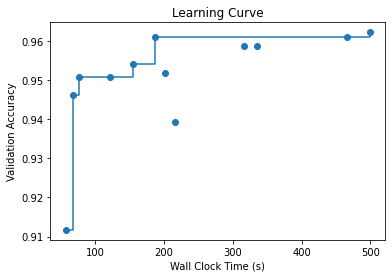

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Other Tasks

Besides sequence classification, FLAML currently also supports four other tasks (more tasks are to be supported, which can be found on FLAML's documentation website https://microsoft.github.io/FLAML/docs/Examples/AutoML-NLP):

- sequence regression: predicting a float number from the input sequence, e.g., predicting the rating of a hotel review based on the text content;
- token classification: predicting the label of each token in a sequence, e.g., named entity recognition;
- multiple choice: predicting the best second half of a sentence that comes next to the first part of a sentence based on common sensen reasoning. An example is seen below;
- (abstractive) summarization: generating the textual summarization of an input paragraph;

For each task, you only have to change the "Load data and preprocess" with the corresponding data loading process. For example:

### 3.1 Multiple Choice Example

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("swag", split="train").to_pandas().iloc[:10000]
dev_dataset = load_dataset("swag", split="validation").to_pandas().iloc[:10000]
test_dataset = load_dataset("swag", split="test").to_pandas()

custom_sent_keys = [
        "sent1",
        "sent2",
        "ending0",
        "ending1",
        "ending2",
        "ending3",
        "gold-source",
        "video-id",
        "startphrase",
        "fold-ind",
    ]                                                  # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)


In [3]:
train_dataset.head(2)

,video-id,fold-ind,startphrase,sent1,sent2,gold-source,ending0,ending1,ending2,ending3,label
0,anetv_jkn6uvmqwh4,3416,Members of the procession walk down the street...,Members of the procession walk down the street...,A drum line,gold,passes by walking down the street playing thei...,has heard approaching them.,arrives and they're outside dancing and asleep.,turns the lead singer watches the performance.,0
1,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,continues to play as well along the crowd alon...,"continue to play marching, interspersed.",3


In [2]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
ray.init()

automl_settings = {
        "time_budget": 500,                 # setting the time budget
        "task": "multichoice-classification",       # setting the task as multiplechoice-classification
        "hf_args":
            {"output_dir": "data/output/",  # setting the output directory
             "ckpt_per_epoch": 1           # setting the number of checkoints per epoch
             },
        "gpu_per_trial": 1,                 # set to 0 if no GPU is available
        "log_file_name": "seqclass.log",    # set the file to save the log for HPO
        "log_type": "all",                  # the log type for checkpoints: all if keeping all checkpoints, best if only keeping the best checkpoints                        # the batch size for validation (inference)
        "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
        "n_concurrent_trials": 4
    }

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

2022-03-05 10:49:19,370	INFO tune.py:636 -- Total run time: 854.36 seconds (500.76 seconds for the tuning loop).
[flaml.automl: 03-05 10:51:24] {2844} INFO - selected model: None
[I 2022-03-05 10:51:24,732] A new study created in memory with name: optuna


(bundle_reservation_check_func pid=48563) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
(bundle_reservation_check_func pid=48563)   from pandas import MultiIndex, Int64Index
(_trainable_function_wrapper pid=48563) E0305 10:51:26.621583546   53454 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


(_trainable_function_wrapper pid=48563) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_trainable_function_wrapper pid=48563)   warnings.warn(


(_trainable_function_wrapper pid=48563) {'loss': 1.3, 'learning_rate': 1.5134989941455831e-05, 'epoch': 1.0}
(_trainable_function_wrapper pid=48563) {'loss': 0.8824, 'learning_rate': 1.4338411523484471e-05, 'epoch': 2.0}


(_trainable_function_wrapper pid=48563) {'loss': 0.3826, 'learning_rate': 8.193378013419697e-06, 'epoch': 3.0}


(_trainable_function_wrapper pid=48563) {'loss': 0.2274, 'learning_rate': 2.0483445033549243e-06, 'epoch': 4.0}


(_trainable_function_wrapper pid=48563) {'train_runtime': 24.376, 'train_samples_per_second': 15.865, 'train_steps_per_second': 1.149, 'train_loss': 0.6980938911437988, 'epoch': 4.0}


2022-03-05 10:52:01,485	WARNING util.py:163 -- The `fetch_result` operation took 0.519 s, which may be a performance bottleneck.
2022-03-05 10:52:01,492	WARNING util.py:163 -- The `process_trial` operation took 0.527 s, which may be a performance bottleneck.


Trial _trainable_function_wrapper_41bb9a64 reported train_time=33.32 with parameters={'learning_rate': 1.9459272781871782e-05, 'num_train_epochs': 3.8672508737242617, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.3, 'weight_decay': 0.07191806885282034, 'adam_epsilon': 1.401371644431578e-08, 'seed': 44, 'global_max_steps': 28, 'learner': 'transformer'}.
Trial _trainable_function_wrapper_41bb9a64 completed. Last result: estimator=<flaml.model.TransformersEstimator object at 0x7f3954607d30>,train_time=33.31933665275574


Trial name,status,loc,adam_epsilon,global_max_steps,learner,learning_rate,num_train_epochs,per_device_train_batch_size,seed,warmup_ratio,weight_decay,iter,total time (s),train_time
_trainable_function_wrapper_41bb9a64,TERMINATED,155.246.89.124:48563,1.40137e-08,28,transformer,1.94593e-05,3.86725,16,44,0.3,0.0719181,1,33.3197,33.3193


2022-03-05 10:52:19,047	INFO tune.py:636 -- Total run time: 54.31 seconds (38.20 seconds for the tuning loop).
[flaml.automl: 03-05 10:52:25] {2954} INFO - retrain transformer for 33.3s
[flaml.automl: 03-05 10:52:25] {2961} INFO - retrained model: RobertaForMultipleChoice(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=7

{'Current Learner': 'transformer', 'Current Sample': 100, 'Current Hyper-parameters': {'learning_rate': 2.756931081948468e-05, 'num_train_epochs': 0.779642815738325, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.22687283276786924, 'weight_decay': 0.29321163598694155, 'adam_epsilon': 3.967681317378338e-08, 'seed': 43, 'global_max_steps': 6, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 2.756931081948468e-05, 'num_train_epochs': 0.779642815738325, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.22687283276786924, 'weight_decay': 0.29321163598694155, 'adam_epsilon': 3.967681317378338e-08, 'seed': 43, 'global_max_steps': 6, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 100, 'Current Hyper-parameters': {'learning_rate': 0.0003745428041684987, 'num_train_epochs': 0.34031242063876355, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.25315902229010456, 'weight_decay': 0.0775263435425649, 'a

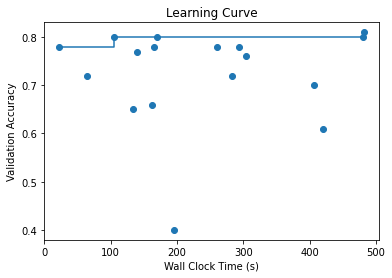

In [3]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

### 3.2 Text Summarization Example

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("xsum", split="train").to_pandas().iloc[0:100]
print(len(train_dataset))
dev_dataset = load_dataset("xsum", split="validation").to_pandas().iloc[0:100]
test_dataset = load_dataset("xsum", split="test").to_pandas().iloc[0:100]

custom_sent_keys = ["document"]       # specify the column names of the input sentences
label_key = "summary"                 # specify the column name of the label                              

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)
Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


100


Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


In [2]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
ray.init()

automl_settings = {
        "time_budget": 500,                 # setting the time budget
        "task": "summarization",       # setting the task as summarization
        "hf_args":
            {"output_dir": "data/output/",  # setting the output directory
             "ckpt_per_epoch": 1,           # setting the number of checkoints per epoch
             "model_path": "t5-small"
             },
        "gpu_per_trial": 1,                 # set to 0 if no GPU is available
        "log_file_name": "seqclass.log",    # set the file to save the log for HPO
        "log_type": "all",                  # the log type for checkpoints: all if keeping all checkpoints, best if only keeping the best checkpoints                        # the batch size for validation (inference)
        "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
        "n_concurrent_trials": 1
    }

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

Trial name,# failures,error file
train_0b280ae2,1,"/data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-03-05_12-42-38/train_0b280ae2_3_adam_epsilon=1e-06,generation_max_length=16,generation_num_beams=3,global_max_steps=9223372036854775807,learner=t_2022-03-05_12-44-26/error.txt"
train_0ca275af,1,"/data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-03-05_12-42-38/train_0ca275af_4_adam_epsilon=1e-06,generation_max_length=128,generation_num_beams=3,global_max_steps=9223372036854775807,learner=_2022-03-05_12-44-28/error.txt"
train_0dfcee49,1,"/data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-03-05_12-42-38/train_0dfcee49_5_adam_epsilon=7.5842e-08,generation_max_length=32,generation_num_beams=3,global_max_steps=9223372036854775807,lear_2022-03-05_12-44-29/error.txt"
train_0efd49e6,1,"/data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-03-05_12-42-38/train_0efd49e6_6_adam_epsilon=1e-08,generation_max_length=128,generation_num_beams=3,global_max_steps=9223372036854775807,learner=_2022-03-05_12-44-31/error.txt"
train_0ffa18a6,1,"/data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-03-05_12-42-38/train_0ffa18a6_7_adam_epsilon=1e-06,generation_max_length=16,generation_num_beams=3,global_max_steps=9223372036854775807,learner=t_2022-03-05_12-44-33/error.txt"
train_0ffa18a9,1,"/data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-03-05_12-42-38/train_0ffa18a9_8_adam_epsilon=2.5054e-08,generation_max_length=128,generation_num_beams=3,global_max_steps=9223372036854775807,lea_2022-03-05_12-44-34/error.txt"
train_118f2c43,1,"/data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-03-05_12-42-38/train_118f2c43_9_adam_epsilon=1e-06,generation_max_length=16,generation_num_beams=3,global_max_steps=9223372036854775807,learner=t_2022-03-05_12-44-36/error.txt"
train_128d54b7,1,"/data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-03-05_12-42-38/train_128d54b7_10_adam_epsilon=1e-06,generation_max_length=128,generation_num_beams=4,global_max_steps=9223372036854775807,learner_2022-03-05_12-44-38/error.txt"
train_1396739d,1,"/data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-03-05_12-42-38/train_1396739d_11_adam_epsilon=4.2308e-07,generation_max_length=16,generation_num_beams=2,global_max_steps=9223372036854775807,lea_2022-03-05_12-44-39/error.txt"
train_14f46c8a,1,"/data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-03-05_12-42-38/train_14f46c8a_12_adam_epsilon=2.5541e-07,generation_max_length=128,generation_num_beams=4,global_max_steps=9223372036854775807,le_2022-03-05_12-44-41/error.txt"


2022-03-05 12:52:32,721	ERROR tune.py:632 -- Trials did not complete: [train_0b280ae2, train_0ca275af, train_0dfcee49, train_0efd49e6, train_0ffa18a6, train_0ffa18a9, train_118f2c43, train_128d54b7, train_1396739d, train_14f46c8a, train_15faeb9a, train_15faeb9d, train_18437ae8, train_18437aeb, train_19d90617, train_1ad790b5, train_1bd0b041, train_1d309d6a, train_1e2c51f0, train_1e2c51f3, train_1fca0d1a, train_211628f1, train_222534df, train_232a42df, train_242507f1, train_255706b5, train_26b001c8, train_26b001cb, train_27b235de]
2022-03-05 12:52:32,727	INFO tune.py:636 -- Total run time: 594.13 seconds (501.03 seconds for the tuning loop).
[flaml.automl: 03-05 12:52:56] {2844} INFO - selected model: None
[I 2022-03-05 12:52:56,573] A new study created in memory with name: optuna


(bundle_reservation_check_func pid=9111) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
(bundle_reservation_check_func pid=9111)   from pandas import MultiIndex, Int64Index
(_trainable_function_wrapper pid=9111) E0305 12:52:58.520134384   12789 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


(_trainable_function_wrapper pid=9111) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_trainable_function_wrapper pid=9111)   warnings.warn(


(_trainable_function_wrapper pid=9111) {'loss': 13.0666, 'learning_rate': 9.565217391304349e-07, 'epoch': 1.04}
(_trainable_function_wrapper pid=9111) {'loss': 13.0462, 'learning_rate': 6.739130434782609e-07, 'epoch': 2.08}


(_trainable_function_wrapper pid=9111) {'loss': 12.9494, 'learning_rate': 3.9130434782608694e-07, 'epoch': 3.12}
(_trainable_function_wrapper pid=9111) {'loss': 12.9611, 'learning_rate': 1.1956521739130436e-07, 'epoch': 4.16}


(_trainable_function_wrapper pid=9111) {'train_runtime': 15.9157, 'train_samples_per_second': 27.533, 'train_steps_per_second': 6.911, 'train_loss': 13.020873815363103, 'epoch': 4.4}


Trial _trainable_function_wrapper_3c039e62 reported train_time=23.72 with parameters={'learning_rate': 1e-06, 'num_train_epochs': 4.382061530598035, 'per_device_train_batch_size': 4, 'warmup_ratio': 0.1587022093363136, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 44, 'global_max_steps': 110, 'generation_num_beams': 2, 'generation_max_length': 16, 'learner': 'transformer'}.
Trial _trainable_function_wrapper_3c039e62 completed. Last result: estimator=<flaml.model.TransformersEstimator object at 0x7f5ff4a6c4c0>,train_time=23.72007727622986


Trial name,status,loc,adam_epsilon,generation_max_length,generation_num_beams,global_max_steps,learner,learning_rate,num_train_epochs,per_device_train_batch_size,seed,warmup_ratio,weight_decay,iter,total time (s),train_time
_trainable_function_wrapper_3c039e62,TERMINATED,155.246.89.124:9111,1e-06,16,2,110,transformer,1e-06,4.38206,4,44,0.158702,0,1,23.7204,23.7201


2022-03-05 12:53:31,720	INFO tune.py:636 -- Total run time: 35.15 seconds (26.98 seconds for the tuning loop).
[flaml.automl: 03-05 12:53:35] {2954} INFO - retrain transformer for 23.7s
[flaml.automl: 03-05 12:53:35] {2961} INFO - retrained model: T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
    

In [ ]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

: 